In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
 import os
import nltk
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Download NLTK tokenizer data if not already downloaded
nltk.download('punkt')

# Set up paths based on the extracted folder structure:
# archive/
#   ├── Images
#   └── captions.txt
# Change the following path to where your archive.zip is located in Google Drive.
zip_path = '/content/drive/MyDrive/archive.zip'

# Unzip it
!unzip -q {zip_path} -d archive

# Now set your base path to the extracted folder
base_path = "./archive"
dataset_root = os.path.join(base_path, "Images")
captions_file = os.path.join(base_path, "captions.txt")


print("Image folder:", dataset_root)
print("Captions file:", captions_file)

# Verify the structure (optional)
!ls -l {dataset_root}


Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Streaming output truncated to the last 5000 lines.
-rw-r--r-- 1 root root  65679 Apr 27  2020 2844747252_64567cf14a.jpg
-rw-r--r-- 1 root root 119918 Apr 27  2020 2844846111_8c1cbfc75d.jpg
-rw-r--r-- 1 root root 171413 Apr 27  2020 2844963839_ff09cdb81f.jpg
-rw-r--r-- 1 root root 193348 Apr 27  2020 2845246160_d0d1bbd6f0.jpg
-rw-r--r-- 1 root root  70736 Apr 27  2020 2845691057_d4ab89d889.jpg
-rw-r--r-- 1 root root 111711 Apr 27  2020 2845845721_d0bc113ff7.jpg
-rw-r--r-- 1 root root 160979 Apr 27  2020 2846037553_1a1de50709.jpg
-rw-r--r-- 1 root root  76823 Apr 27  2020 2846785268_904c5fcf9f.jpg
-rw-r--r-- 1 root root 219425 Apr 27  2020 2846843520_b0e6211478.jpg
-rw-r--r-- 1 root root 137247 Apr 27  2020 2847514745_9a35493023.jpg
-rw-r--r-- 1 root root  71116 Apr 27  2020 2847615962_c330bded6e.jpg
-rw-r--r-- 1 root root 134929 Apr 27  2020 2847859796_4d9cb0d31f.jpg
-rw-r--r-- 1 root root 146325 Apr 27  2020 2848266893_9693c66275.jpg
-rw-r--r-- 1 root root 226184 Apr 27  2020 284857108

In [ ]:
class Vocabulary:
    """Simple Vocabulary wrapper for mapping words to indices and vice versa."""
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        # Special tokens
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        return nltk.tokenize.word_tokenize(text.lower())

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4  # Start indexing after the special tokens
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] += 1
                # Add the word if it reaches the frequency threshold and is not already added.
                if frequencies[word] == self.freq_threshold and word not in self.stoi:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [self.stoi.get(word, self.stoi["<unk>"]) for word in tokenized_text]


In [ ]:
class Flickr8kDataset(Dataset):
    def __init__(self, root_dir, captions_file, vocabulary, transform=None):
        """
        Args:
            root_dir: Directory with images.
            captions_file: Path to the captions file.
            vocabulary: A Vocabulary object.
            transform: Image transformations.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocabulary

        self.image_captions = []
        # Read the captions file. Adjust the splitting method based on your captions file format.
        with open(captions_file, 'r') as f:
            for line in f:
                line = line.strip()
                if len(line) == 0:
                    continue
                # Try splitting by tab first; if not, use a single space.
                if "\t" in line:
                    tokens = line.split("\t")
                else:
                    tokens = line.split(" ", 1)  # This was splitting with no limit
                if len(tokens) < 2:
                    continue
                # The image id might contain extra characters after .jpg that need to be removed.
                img_id = tokens[0].strip().split(',')[0] # Modification to extract the correct image ID.
                caption = tokens[1].strip()
                self.image_captions.append((img_id, caption))

    def __len__(self):
        return len(self.image_captions)

    def __getitem__(self, index):
        img_id, caption = self.image_captions[index]
        img_path = os.path.join(self.root_dir, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)

        # Add the start and end tokens to the caption.
        numericalized_caption = [self.vocab.stoi["<start>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<end>"])

        caption_tensor = torch.tensor(numericalized_caption)
        return image, caption_tensor

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Load all captions from the captions file.
all_captions = []
with open(captions_file, 'r') as f:
    for line in f:
        line = line.strip()
        if len(line) == 0:
            continue
        if "\t" in line:
            tokens = line.split("\t")
        else:
            tokens = line.split(" ", 1)
        if len(tokens) < 2:
            continue
        caption = tokens[1].strip()
        all_captions.append(caption)

# Create and build the vocabulary. Adjust freq_threshold if needed.
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(all_captions)
print("Vocabulary Size:", len(vocab))


Vocabulary Size: 2993


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence  # Import pad_sequence

# ... (rest of your code) ...

def custom_collate(batch):
    """
    Pads captions to create batches of uniform size.
    """
    imgs = [item[0] for item in batch]
    captions = [item[1] for item in batch]

    # Pad captions
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab.stoi["<pad>"])

    # Stack images
    imgs = torch.stack(imgs, dim=0)

    return imgs, captions
# Create the dataset instance using the earlier paths and classes.
dataset = Flickr8kDataset(root_dir=dataset_root, captions_file=captions_file, vocabulary=vocab, transform=transform)

# Create a DataLoader for iterating through the dataset.
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, collate_fn=custom_collate)


# Test one batch from the DataLoader
for imgs, captions in dataloader:
    print("Images batch shape:", imgs.shape)
    print("Captions batch shape:", captions.shape)
    break


Images batch shape: torch.Size([32, 3, 224, 224])
Captions batch shape: torch.Size([32, 25])


In [ ]:
import torch.nn as nn
import torchvision.models as models

# Encoder for Attention: Returns spatial features to support attention.
class EncoderCNN_Attn(nn.Module):
    def __init__(self, embed_size):
        """
        Use the pretrained ResNet50 to extract spatial features.
        The final conv features (before average pooling) are taken,
        and a 1x1 convolution reduces the channel dimension to embed_size.
        """
        super(EncoderCNN_Attn, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # Remove average pooling and fc layers so that we get feature maps.
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        # Optional: ensure fixed feature map size using adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))
        # 1x1 convolution to reduce feature maps from 2048 channels to embed_size.
        self.conv = nn.Conv2d(2048, embed_size, kernel_size=1)

    def forward(self, images):
        # images: (batch_size, 3, height, width)
        features = self.resnet(images)              # (batch, 2048, H, W)
        features = self.adaptive_pool(features)       # (batch, 2048, 14, 14)
        features = self.conv(features)                # (batch, embed_size, 14, 14)
        # Reshape to (batch, num_features, embed_size)
        batch_size, embed_size, H, W = features.size()
        features = features.view(batch_size, embed_size, -1)  # (batch, embed_size, 196)
        features = features.permute(0, 2, 1)  # (batch, 196, embed_size)
        return features

# Attention Module (Additive Attention)
class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim, attention_dim):
        """
        feature_dim: Dimension of encoder features (embed_size)
        hidden_dim: Dimension of decoder hidden state
        attention_dim: Dimension of the attention space
        """
        super(Attention, self).__init__()
        self.attention_feature = nn.Linear(feature_dim, attention_dim)
        self.attention_hidden = nn.Linear(hidden_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, hidden):
        # features: (batch, num_features, feature_dim)
        # hidden: (batch, hidden_dim); we use the current hidden state
        att1 = self.attention_feature(features)                 # (batch, num_features, attention_dim)
        att2 = self.attention_hidden(hidden).unsqueeze(1)         # (batch, 1, attention_dim)
        att = self.full_att(self.relu(att1 + att2)).squeeze(2)      # (batch, num_features)
        alpha = self.softmax(att)                                 # (batch, num_features)
        # Compute the context vector as the weighted sum of the features.
        attention_weighted_encoding = (features * alpha.unsqueeze(2)).sum(dim=1)  # (batch, feature_dim)
        return attention_weighted_encoding, alpha

# Decoder (LSTM) with Attention
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, attention_dim, feature_dim, num_layers=1, dropout=0.5):
        """
        embed_size: Size of word embeddings (should match encoder's output if you wish)
        hidden_size: Hidden size of the LSTM
        vocab_size: Vocabulary size (for final classification layer)
        attention_dim: Dimension for the attention layer
        feature_dim: Dimension of encoder features (same as embed_size from the encoder)
        """
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(feature_dim, hidden_size, attention_dim)
        # LSTM input dimension = word embedding + encoded image feature (context vector)
        self.lstm = nn.LSTM(embed_size + feature_dim, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, captions):
        """
        features: (batch, num_features, feature_dim) from the encoder.
        captions: (batch, max_caption_length)
        """
        # Embed captions (excluding the last word since we'll predict the next)
        embeddings = self.embed(captions)  # (batch, caption_len, embed_size)

        batch_size = features.size(0)
        seq_length = embeddings.size(1)

        # Initialize LSTM hidden and cell states with zeros
        hidden_state = torch.zeros((1, batch_size, self.lstm.hidden_size), device=features.device)
        cell_state = torch.zeros((1, batch_size, self.lstm.hidden_size), device=features.device)

        outputs = []
        # Process each time step
        for t in range(seq_length):
            # Compute attention using the current hidden state (squeeze since hidden_state is 1 x batch x hidden)
            context, alpha = self.attention(features, hidden_state.squeeze(0))
            # Concatenate the context vector and current word embedding
            lstm_input = torch.cat((embeddings[:, t, :], context), dim=1).unsqueeze(1)  # (batch, 1, embed_size+feature_dim)
            out, (hidden_state, cell_state) = self.lstm(lstm_input, (hidden_state, cell_state))  # out: (batch, 1, hidden_size)
            out = self.linear(self.dropout(out.squeeze(1)))  # (batch, vocab_size)
            outputs.append(out)

        # Stack outputs across time steps: (batch, seq_length, vocab_size)
        outputs = torch.stack(outputs, dim=1)
        return outputs


In [ ]:
import torch.optim as optim

# Hyperparameters
embed_size = 256      # Size of image features and word embeddings
hidden_size = 512     # LSTM hidden state size
attention_dim = 256   # Dimension for the attention module
num_epochs = 10       # Number of training epochs
learning_rate = 1e-3

# Vocabulary size from your built vocabulary
vocab_size = len(vocab)

# Instantiate the models; here we use the attention-based encoder.
encoder = EncoderCNN_Attn(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, attention_dim, embed_size).to(device)

# Loss and optimizer. Note: we ignore the <pad> token in the loss.
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<pad>"])
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = optim.Adam(params, lr=learning_rate)

print("Starting training...")

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    epoch_loss = 0.0

    for imgs, captions in dataloader:
        imgs = imgs.to(device)
        captions = captions.to(device)
        optimizer.zero_grad()

        # Forward pass: encoder produces features from images.
        # For attention-based decoding, features: (batch, num_features, embed_size)
        features = encoder(imgs)
        # Use captions excluding the last token as input to the decoder.
        outputs = decoder(features, captions[:, :-1])

        # Targets are the captions from the 2nd token onward.
        targets = captions[:, 1:]

        # Reshape outputs and targets for computing the loss.
        outputs = outputs.reshape(-1, outputs.size(2))  # (batch * seq_length, vocab_size)
        targets = targets.reshape(-1)                   # (batch * seq_length)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Save checkpoint at the end of each epoch
    checkpoint = {
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pth')
    print(f"Checkpoint saved for epoch {epoch+1}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


Starting training...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch [1/10], Loss: 3.6456
Checkpoint saved for epoch 1
Epoch [2/10], Loss: 3.0992
Checkpoint saved for epoch 2
Epoch [3/10], Loss: 2.9210
Checkpoint saved for epoch 3
Epoch [4/10], Loss: 2.7983
Checkpoint saved for epoch 4
Epoch [5/10], Loss: 2.6991
Checkpoint saved for epoch 5
Epoch [6/10], Loss: 2.6133
Checkpoint saved for epoch 6
Epoch [7/10], Loss: 2.5317
Checkpoint saved for epoch 7
Epoch [8/10], Loss: 2.4635
Checkpoint saved for epoch 8
Epoch [9/10], Loss: 2.3953
Checkpoint saved for epoch 9
Epoch [10/10], Loss: 2.3358
Checkpoint saved for epoch 10


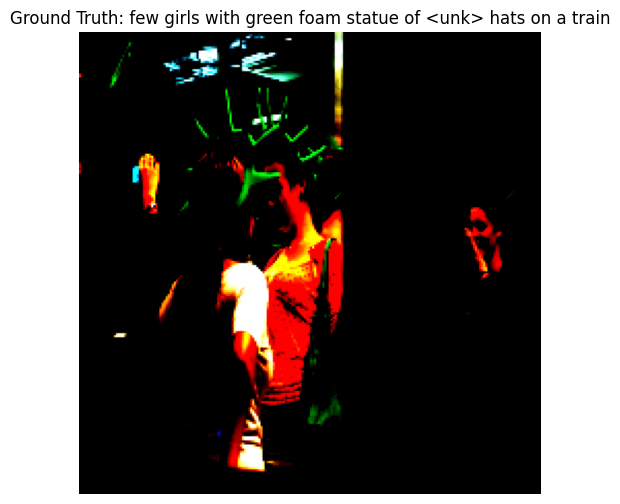

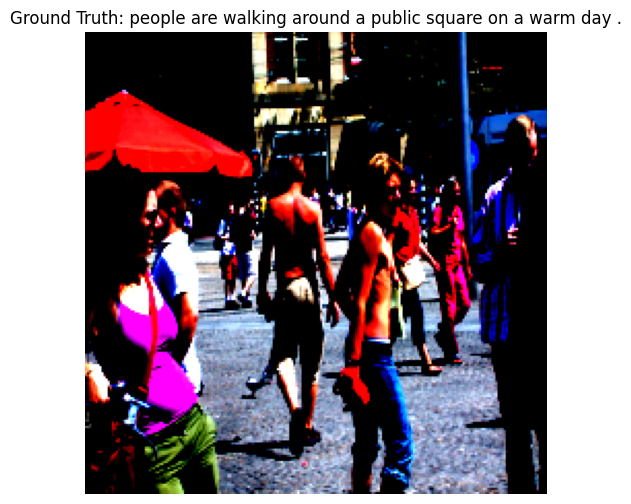

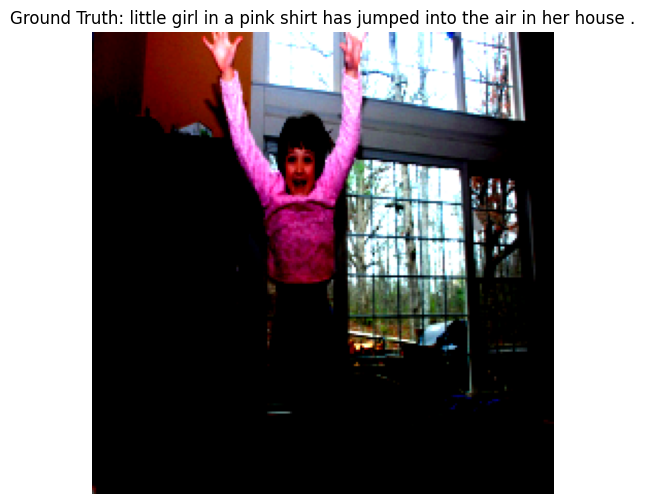

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def decode_caption(caption_tensor, vocab):
    """
    Convert a tensor of word indices into a readable caption string.
    Skips the <start> token, stops at <end>.
    """
    words = []
    for idx in caption_tensor:
        word = vocab.itos[idx.item()]
        if word == "<end>":
            break
        if word != "<start>":
            words.append(word)
    return " ".join(words)

# Get one batch from the DataLoader and display a few images with their captions.
for imgs, captions in dataloader:
    for i in range(min(len(imgs), 3)):  # change 3 to however many samples you want
        img = imgs[i]
        gt_caption = decode_caption(captions[i], vocab)
        plt.figure(figsize=(8, 6))
        # Transpose image from (C, H, W) to (H, W, C)
        plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
        plt.title("Ground Truth: " + gt_caption)
        plt.axis("off")
        plt.show()
    break  # Only process one batch


Predicted Caption: group of people are walking through the snow .
Ground Truth Caption: young people sitting on a rail above a crowded beach .


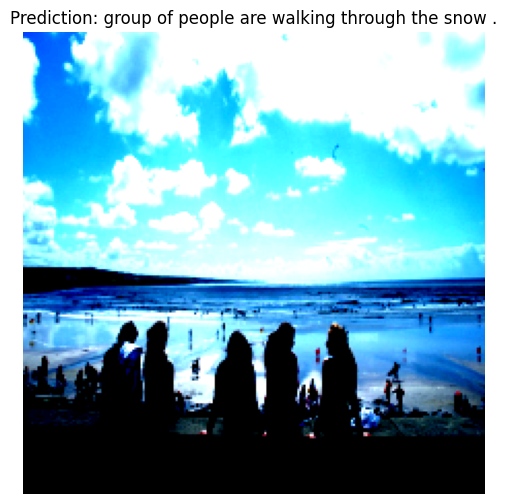

In [ ]:
def generate_caption(encoder, decoder, image, vocab, max_length=20):
    """
    Generates a caption for a given image using greedy decoding.

    Args:
      encoder: Trained encoder model.
      decoder: Trained decoder model.
      image: A single image tensor of shape (3, H, W).
      vocab: Vocabulary object for converting indices to words.
      max_length: Maximum number of words to generate.

    Returns:
      Generated caption as a string.
    """
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Add batch dimension: (1, 3, H, W)
        image = image.to(device).unsqueeze(0)
        features = encoder(image)  # (1, num_features, embed_size)

        # Initialize LSTM states similarly as in training.
        hidden_state = torch.zeros((1, 1, decoder.lstm.hidden_size), device=device)
        cell_state = torch.zeros((1, 1, decoder.lstm.hidden_size), device=device)

        # Initialize with the <start> token.
        current_token = torch.tensor([vocab.stoi["<start>"]], device=device).unsqueeze(0)  # (1, 1)
        generated_words = []

        for t in range(max_length):
            # Get embedding for the current token
            embedding = decoder.embed(current_token)  # (1, 1, embed_size)
            # Compute attention context using the current hidden state.
            context, alpha = decoder.attention(features, hidden_state.squeeze(0))  # context: (1, embed_size)
            # Concatenate embedding and context to form LSTM input.
            lstm_input = torch.cat((embedding.squeeze(1), context), dim=1).unsqueeze(1)  # (1, 1, embed_size+embed_size)
            out, (hidden_state, cell_state) = decoder.lstm(lstm_input, (hidden_state, cell_state))
            out = decoder.linear(decoder.dropout(out.squeeze(1)))  # (1, vocab_size)
            predicted = out.argmax(dim=1)  # (1,)
            predicted_idx = predicted.item()

            # Stop if the predicted token is the <end> token.
            if vocab.itos[predicted_idx] == "<end>":
                break
            generated_words.append(vocab.itos[predicted_idx])
            current_token = predicted.unsqueeze(0)  # Use the predicted token as next input

        return " ".join(generated_words)

# Test the caption generation on a sample image from the dataset.
sample_image, sample_caption = dataset[179]  # Get the first image (or choose any index)
predicted_caption = generate_caption(encoder, decoder, sample_image, vocab)
ground_truth_caption = decode_caption(sample_caption, vocab)

print("Predicted Caption:", predicted_caption)
print("Ground Truth Caption:", ground_truth_caption)

# Display the sample image along with the predicted caption.
plt.figure(figsize=(8, 6))
plt.imshow(np.transpose(sample_image.cpu().numpy(), (1, 2, 0)))
plt.title("Prediction: " + predicted_caption)
plt.axis("off")
plt.show()


In [ ]:
import torch.optim as optim

# ---------------------------
# Load checkpoint from epoch 10
# ---------------------------
checkpoint = torch.load('checkpoint_epoch_10.pth', map_location=device)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1  # This should set start_epoch to 11

print(f"Resuming training from epoch {start_epoch}...")

# ---------------------------
# Update the learning rate for fine-tuning (reduce it)
# ---------------------------
new_lr = 1e-4  # Lower learning rate
for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr
print(f"Learning rate updated to {new_lr}")

# ---------------------------
# Continue training for additional epochs (e.g., 4 more epochs)
# ---------------------------
additional_epochs = 4

for epoch in range(start_epoch, start_epoch + additional_epochs):
    encoder.train()
    decoder.train()
    epoch_loss = 0.0

    for imgs, captions in dataloader:
        imgs = imgs.to(device)
        captions = captions.to(device)
        optimizer.zero_grad()

        # Forward pass: Get features from encoder
        features = encoder(imgs)
        # Predict using the decoder; use captions excluding the last token as input
        outputs = decoder(features, captions[:, :-1])
        targets = captions[:, 1:]

        # Reshape outputs and targets to compute loss
        outputs = outputs.reshape(-1, outputs.size(2))  # (batch*seq_len, vocab_size)
        targets = targets.reshape(-1)                   # (batch*seq_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch}/{start_epoch + additional_epochs - 1}], Loss: {avg_loss:.4f}")

    # Save checkpoint at the end of the epoch
    checkpoint = {
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
    print(f"Checkpoint saved for epoch {epoch}")


Resuming training from epoch 10...
Learning rate updated to 0.0001
Epoch [10/13], Loss: 2.1564
Checkpoint saved for epoch 10
Epoch [11/13], Loss: 2.1081
Checkpoint saved for epoch 11
Epoch [12/13], Loss: 2.0800
Checkpoint saved for epoch 12
Epoch [13/13], Loss: 2.0573
Checkpoint saved for epoch 13


In [ ]:
import torch
from google.colab import drive

# --- Save locally ---
# Use the current epoch (assumed to be defined as 'epoch') and the average loss (avg_loss)
checkpoint = {
    'epoch': epoch,  # This is your current epoch variable
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}

# Save to local file in the session's storage
local_save_path = 'model_checkpoint.pth'
torch.save(checkpoint, local_save_path)
print("Model checkpoint saved locally as", local_save_path)

# --- Optionally, save to Google Drive ---
# Mount your Google Drive if not already mounted.
drive.mount('/content/drive')

# Set the path where you want to save the model in your Drive (adjust the path as necessary)
drive_save_path = '/content/drive/MyDrive/model_checkpoint.pth'
torch.save(checkpoint, drive_save_path)
print("Model checkpoint saved to Google Drive at", drive_save_path)


Model checkpoint saved locally as model_checkpoint.pth
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model checkpoint saved to Google Drive at /content/drive/MyDrive/model_checkpoint.pth


Predicted Caption: man is riding a bike on a dirt path .
Ground Truth Caption: man dressed in camouflage riding a motorbike


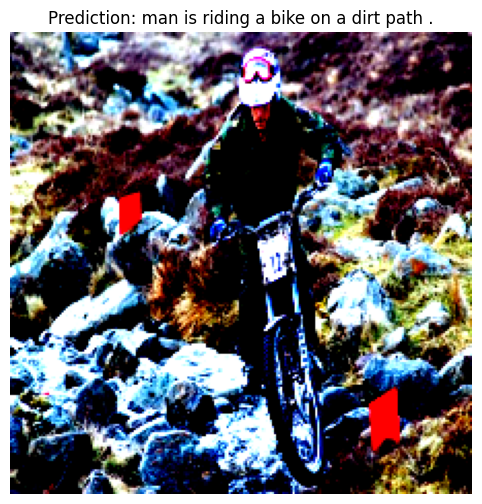

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_caption(encoder, decoder, image, vocab, max_length=20):
    """
    Generates a caption for a given image using greedy decoding.

    Args:
      encoder: Trained encoder model.
      decoder: Trained decoder model.
      image: A single image tensor (shape: [3, H, W]).
      vocab: Vocabulary object to convert indices to words.
      max_length: Maximum number of words to generate.

    Returns:
      caption: Generated caption as a string.
    """
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Add a batch dimension and send image to device
        image = image.to(device).unsqueeze(0)  # Now (1, 3, H, W)
        # Extract features from the image using the encoder.
        features = encoder(image)  # (1, num_features, embed_size)

        # Initialize LSTM hidden and cell states
        hidden_state = torch.zeros((1, 1, decoder.lstm.hidden_size), device=device)
        cell_state = torch.zeros((1, 1, decoder.lstm.hidden_size), device=device)

        # Start the caption with the <start> token.
        current_token = torch.tensor([vocab.stoi["<start>"]], device=device).unsqueeze(0)  # (1, 1)
        generated_words = []

        # Generate the caption word-by-word
        for t in range(max_length):
            # Get embedding for current token
            embedding = decoder.embed(current_token)  # (1, 1, embed_size)
            # Compute attention context using the current hidden state
            context, _ = decoder.attention(features, hidden_state.squeeze(0))  # (1, embed_size)
            # Concatenate embedding and context and pass into the LSTM
            lstm_input = torch.cat((embedding.squeeze(1), context), dim=1).unsqueeze(1)  # (1, 1, embed_size+embed_size)
            # Get output from LSTM cell
            out, (hidden_state, cell_state) = decoder.lstm(lstm_input, (hidden_state, cell_state))
            # Compute the predicted word probabilities
            out = decoder.linear(decoder.dropout(out.squeeze(1)))  # (1, vocab_size)
            predicted = out.argmax(dim=1)  # (1,)
            predicted_idx = predicted.item()

            # Stop if we generate the <end> token.
            if vocab.itos[predicted_idx] == "<end>":
                break

            # Append the predicted word and set as the next token.
            generated_words.append(vocab.itos[predicted_idx])
            current_token = predicted.unsqueeze(0)  # (1, 1)

    return " ".join(generated_words)

# Optional: A helper function to convert a caption tensor back into a string.
def decode_caption(caption_tensor, vocab):
    """
    Convert a tensor of word indices to a string caption.
    Skips the <start> token and stops at the <end> token.
    """
    words = []
    for idx in caption_tensor:
        word = vocab.itos[idx.item()]
        if word == "<end>":
            break
        if word != "<start>":
            words.append(word)
    return " ".join(words)

# ----------------------------
# Example usage:
# Get a sample image and its ground truth caption from your dataset.
sample_image, sample_caption = dataset[2765]  # You can change the index if needed.
predicted_caption = generate_caption(encoder, decoder, sample_image, vocab)
ground_truth_caption = decode_caption(sample_caption, vocab)

print("Predicted Caption:", predicted_caption)
print("Ground Truth Caption:", ground_truth_caption)

# Display the sample image along with the predicted caption.
plt.figure(figsize=(8, 6))
plt.imshow(np.transpose(sample_image.cpu().numpy(), (1, 2, 0)))
plt.title("Prediction: " + predicted_caption)
plt.axis("off")
plt.show()


In [ ]:
# Mount Google Drive and save model & vocabulary to fixed locations
from google.colab import drive
drive.mount('/content/drive')

import torch
import pickle

# Define the fixed save paths on your Google Drive.
# These paths will be used for later loading without any modifications.
vocab_save_path = '/content/drive/MyDrive/vocab.pkl'
checkpoint_path = '/content/drive/MyDrive/model_checkpoint.pth'

# Create your checkpoint dictionary.
# Ensure that 'epoch' and 'avg_loss' are the current epoch number and average loss value from your training.
checkpoint = {
    'epoch': epoch,  # Current epoch variable from your training loop
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}

# Save the model checkpoint to Google Drive.
torch.save(checkpoint, checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}")

# Save the vocabulary to Google Drive using pickle.
with open(vocab_save_path, 'wb') as f:
    pickle.dump(vocab, f)
print(f"Vocabulary saved to {vocab_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model checkpoint saved to /content/drive/MyDrive/model_checkpoint.pth
Vocabulary saved to /content/drive/MyDrive/vocab.pkl
